In [2]:
import sys
sys.path.append('/home/npopkov/dll24')

import matplotlib.pyplot as plt
import torch
torch.backends.cudnn.benchmark = True

import numpy as np
import lightning as lt
torch.set_float32_matmul_precision('medium')
import soundfile as sf

from torch.utils.data import DataLoader,Dataset

import h5py
from tqdm.auto import tqdm

class SnippetDatasetHDF(Dataset):
    def __init__(self, hdf, scaling='standard'):
        self.num_rows = 0
        self.size = 2**16
        self.data = []
        self.scaling = scaling
        self.createData(hdf)
        self.lens = [len(sample) for sample in self.data]
        
        if scaling == 'standard':
            self.mean = self.data.mean()
            self.std =  self.data.std()
            self.data = (self.data - self.mean) / self.std
        
        if scaling == 'minmax':
            self.min = self.data.min()
            self.max = self.data.max()
            self.data = (self.data - self.min) / (self.max - self.min)
    
    def __len__(self):
        return self.num_rows
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def createData(self, hdf):
        data = []
        keys = list(hdf.keys())
        self.num_rows = len(keys)
        for key in tqdm(keys):
            sample = hdf[key]['audio'][:]
            if len(sample) > self.size:
               self.num_rows -= 1
               continue
            
            if len(sample) < self.size:
                sample = np.pad(sample, (0, self.size - len(sample)), 'constant')



            data.append(sample)
         
        self.data = torch.tensor(np.array(data)).float()
    
    def retransform(self, data):
        if self.scaling == 'standard':
            return data * self.std + self.mean
        if self.scaling == 'minmax':
            return data * (self.max - self.min) + self.min
         

hdf = h5py.File('../test.hdf5', 'r')
dataset = SnippetDatasetHDF(hdf)
hdf.close()



  0%|          | 0/6675 [00:00<?, ?it/s]

In [3]:
dataset.num_rows

4477

In [4]:
from models.AEA.AEA import AEA
from models.AEA.AEA_linear import AEA_linear

autoencoder = AEA.load_from_checkpoint('/home/npopkov/dll24/notebooks/lightning_logs/version_127/checkpoints/epoch=49-step=7000.ckpt',num_fet=1)
autoencoder.eval()



AEA(
  (encoder): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(2,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv1d(32, 64, kernel_size=(3,), stride=(2,))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv1d(64, 128, kernel_size=(3,), stride=(2,))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv1d(128, 256, kernel_size=(3,), stride=(2,))
    (7): LeakyReLU(negative_slope=0.01)
  )
  (attention): Sequential(
    (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(256, 128, kernel_size=(3,), stride=(2,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose1d(128, 64, kernel_size=(3,), stride=(2,))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose1d(64, 32, kernel_size=(3,), stride=(2,))
    (5): LeakyReLU(negative_slo

In [5]:
dataloader = DataLoader(dataset, batch_size=32,num_workers=30,drop_last=True)


In [6]:
 


# # Train model with audio waveforms
# trainer = lt.Trainer(max_epochs=50)
# trainer.fit(autoencoder, dataloader)

In [7]:
from IPython.display import Audio
samplerate = 32000
real_sample = dataset.retransform(dataset.data[0]) 
Audio(real_sample, rate=samplerate)

In [8]:
# Turn noise into new audio sample with diffusion
latent = autoencoder.attention(autoencoder.encoder(dataset.data[0].unsqueeze(0).unsqueeze(0).to('cuda')))
pred = autoencoder.decoder(latent)
retransformed_pred = (dataset.retransform(pred)).cpu().detach().numpy()
Audio(retransformed_pred[0,0], rate=samplerate)

In [9]:
latent.view(1,-1).shape

torch.Size([1, 1048320])

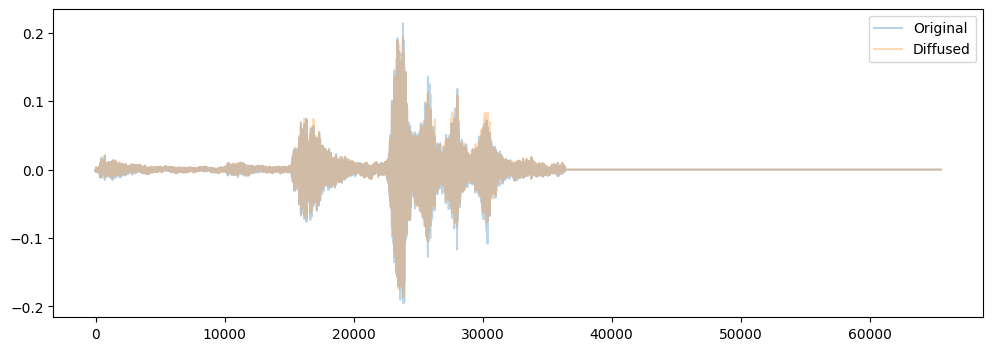

In [10]:
plt.figure(figsize=(12, 4))
plt.plot(real_sample.cpu().numpy(), alpha=0.3, label='Original')
plt.plot(retransformed_pred[0, 0], alpha=0.3, label='Diffused')
plt.legend()

In [11]:
latents = []
for data in dataloader:

    latent = autoencoder.attention(autoencoder.encoder(data.unsqueeze(1).to('cuda')))
    latents.append(latent.cpu().detach().numpy())

In [12]:
np_latents = np.array(latents)

In [13]:
np_latents.shape

(139, 32, 256, 4095)

In [14]:
combined_latents = np_latents.reshape(-1, np_latents.shape[2], np_latents.shape[3])
np.save('latents.npy', combined_latents)

In [15]:
latent_dataset = torch.tensor(combined_latents).float()
latent_dataloader = DataLoader(latent_dataset, batch_size=32, num_workers=30, drop_last=True)

In [16]:
from audio_diffusion_pytorch import DiffusionModel, UNetV0, VDiffusion, VSampler

model = DiffusionModel(
    net_t=UNetV0, # The model type used for diffusion (U-Net V0 in this case)
    in_channels=256, # U-Net: number of input/output (audio) channels
    channels=[8, 32, 64, 128, 256, 512, 512, 1024, 1024], # U-Net: channels at each layer
    factors=[1, 4, 4, 4, 2, 2, 2, 2, 2], # U-Net: downsampling and upsampling factors at each layer
    items=[1, 2, 2, 2, 2, 2, 2, 4, 4], # U-Net: number of repeating items at each layer
    attentions=[0, 0, 0, 0, 0, 1, 1, 1, 1], # U-Net: attention enabled/disabled at each layer
    attention_heads=8, # U-Net: number of attention heads per attention item
    attention_features=64, # U-Net: number of attention features per attention item
    diffusion_t=VDiffusion, # The diffusion method used
    sampler_t=VSampler, # The diffusion sampler used
)

: 

In [17]:
class Lightningwrapper(lt.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        return self.model(x)
    def training_step(self, batch, batch_idx):
        loss = self.model(batch.unsqueeze(1))
        self.log('train_loss', loss)
        return loss
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=3e-4)

lt_model = Lightningwrapper(model)
# Train model with audio waveforms
trainer = lt.Trainer(max_epochs=50)
trainer.fit(lt_model, latent_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2024-08-08 22:09:42.224912: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-08 22:09:42.339724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-08 22:09:42.388467: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-08 22:09:42.401334: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attem